In [15]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
from time import time
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [3]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [4]:
def features_extractor(patch,state,params,extractor):
    tile=patch
    contours, _ = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if state=='positive':
        if len(contours)==1:
            object_area = cv2.contourArea(contours[0])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            object_area = max(areas)
    else:
        if len(contours)==2:
            object_area = cv2.contourArea(contours[0])-cv2.contourArea(contours[1])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            areas=np.sort(areas)
            object_area = areas[-1]-areas[-2]

    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 201)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [x[np.argmin(np.absolute(y-0.1*(j+1)))] for j in range(10)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]/object_area*224*224/100])
    return extracted

In [7]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_region_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_shift/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46
step_size = 22


ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [35]:
%%time
section = 94
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
margin = 200/0.46
extractor = patch_extractor(params)

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif
CPU times: user 838 ms, sys: 1.16 s, total: 2 s
Wall time: 26.6 s


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/94.pkl s3://mousebrainatlas-data/CSHL_shift/MD594/94.pkl
94 VCA 1 / 1
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_region_features/MD594/94.pkl s3://mousebrainatlas-data/CSHL_region_features/MD594/94.pkl
94 finished in  92.0 seconds


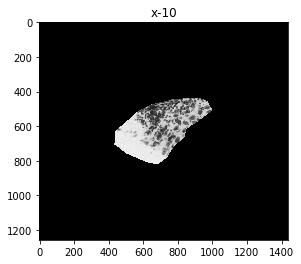

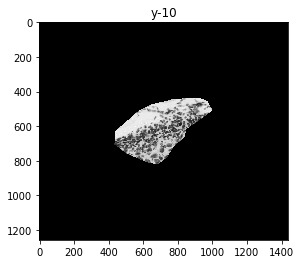

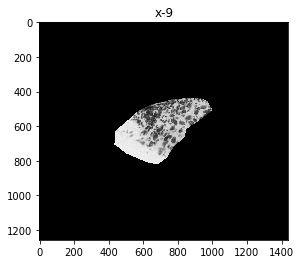

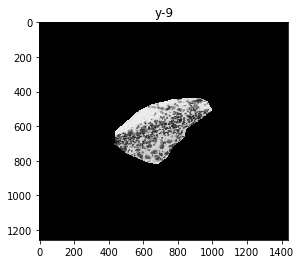

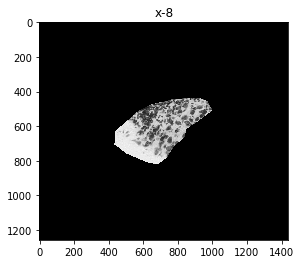

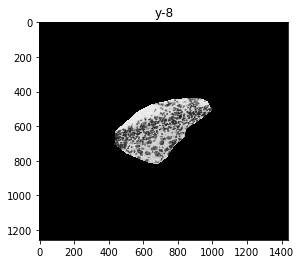

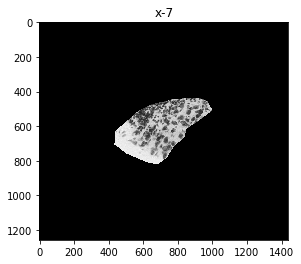

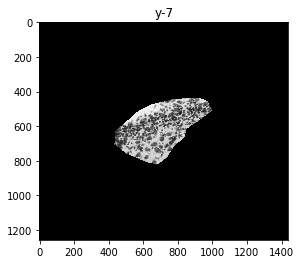

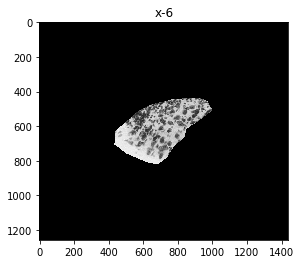

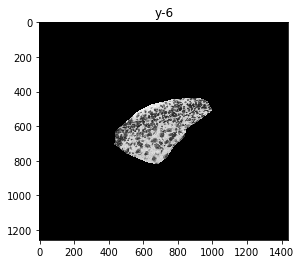

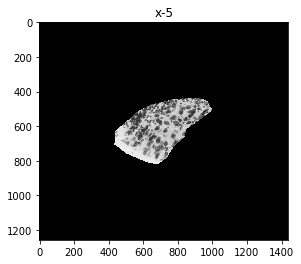

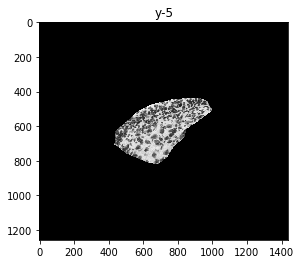

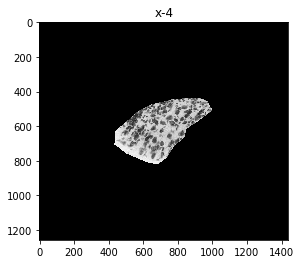

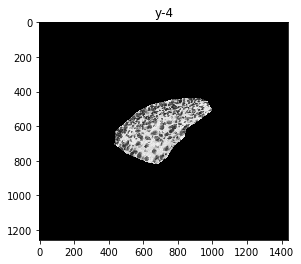

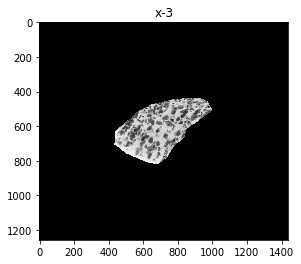

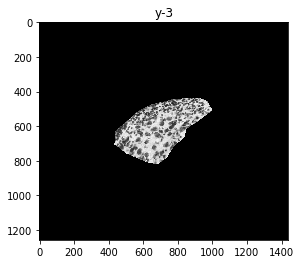

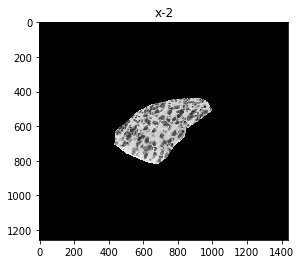

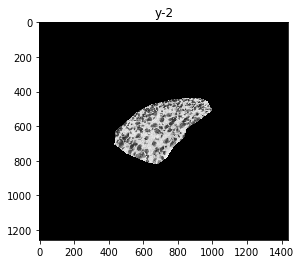

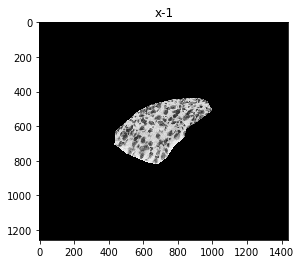

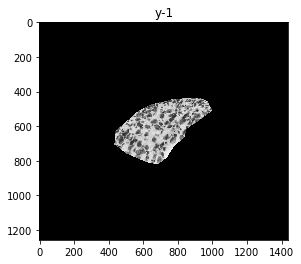

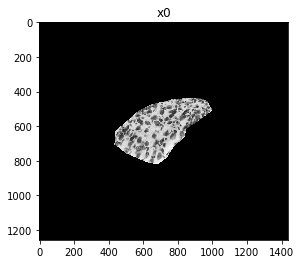

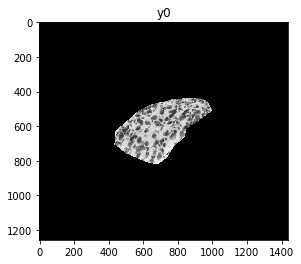

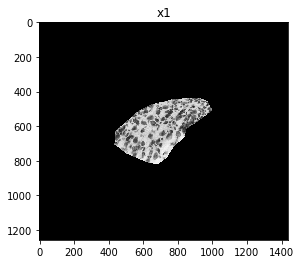

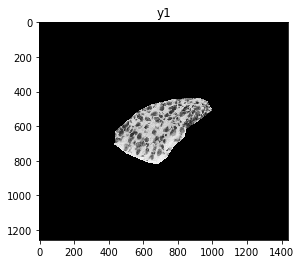

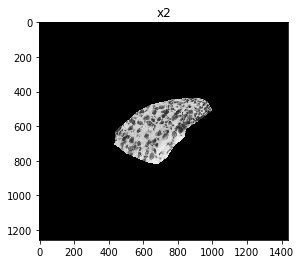

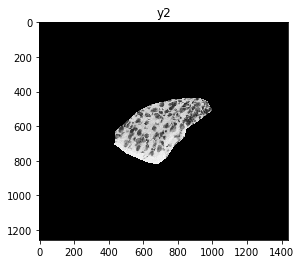

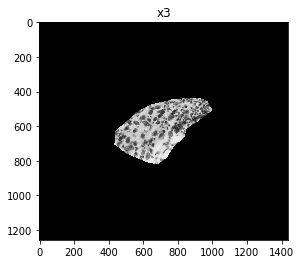

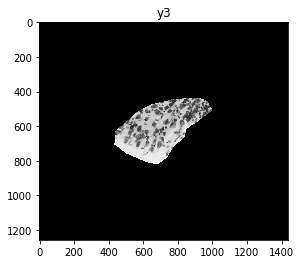

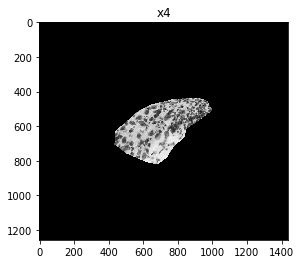

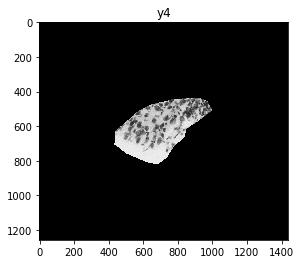

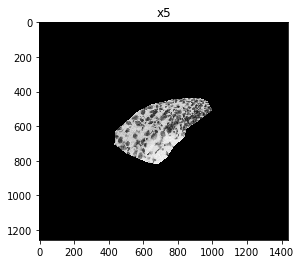

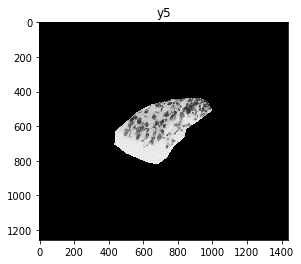

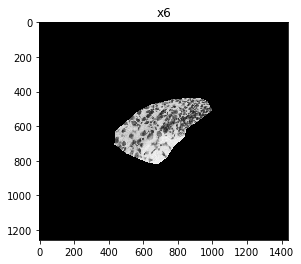

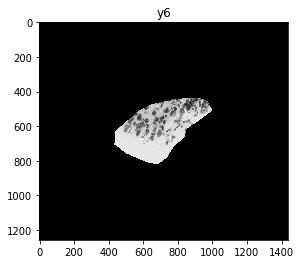

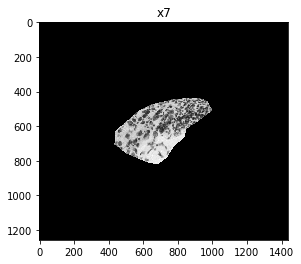

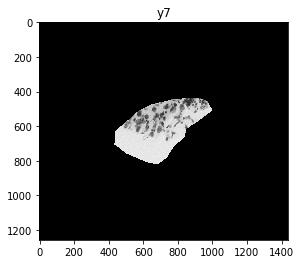

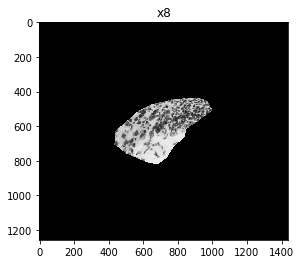

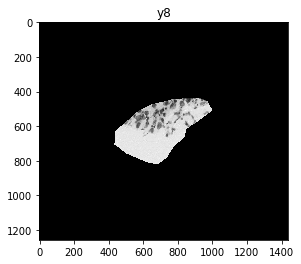

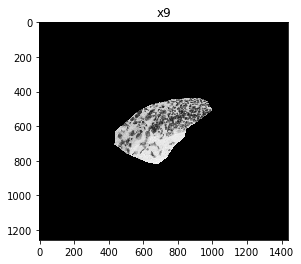

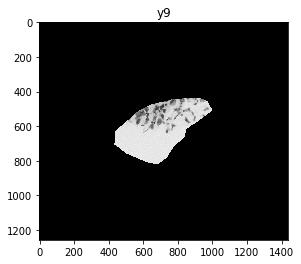

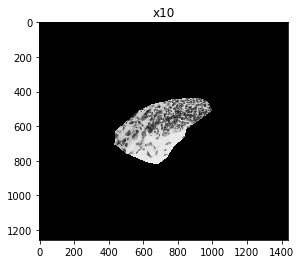

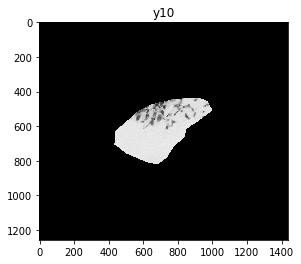

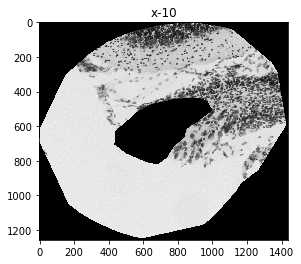

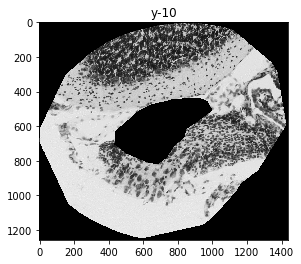

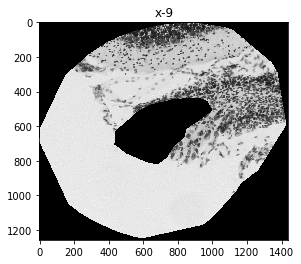

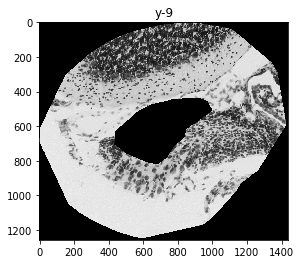

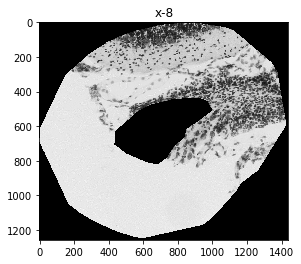

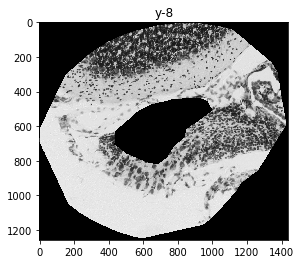

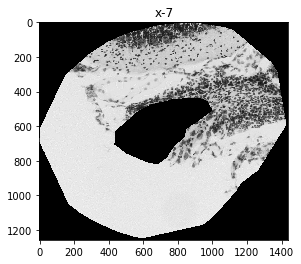

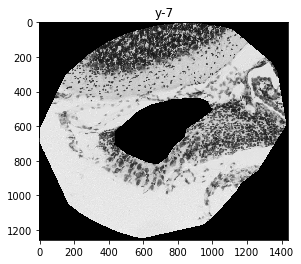

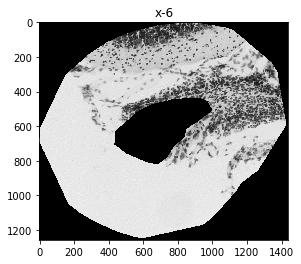

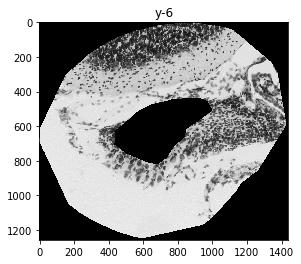

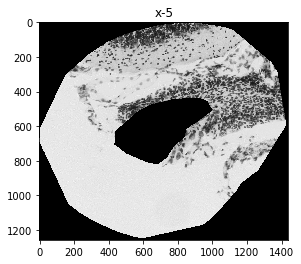

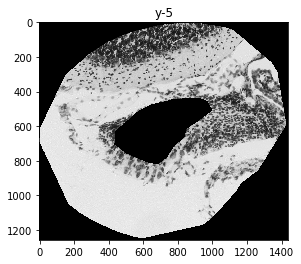

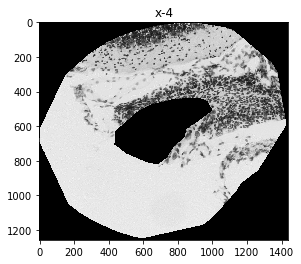

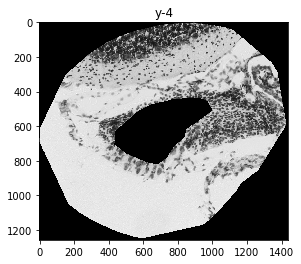

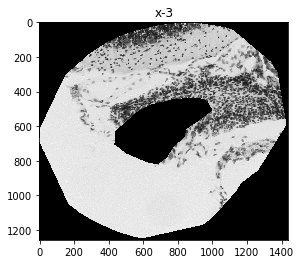

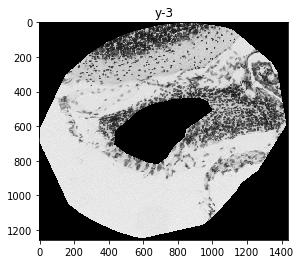

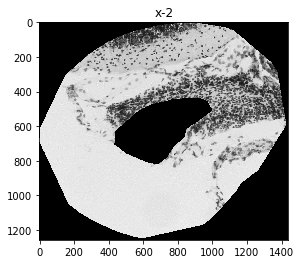

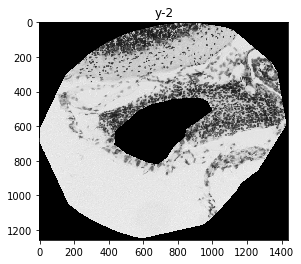

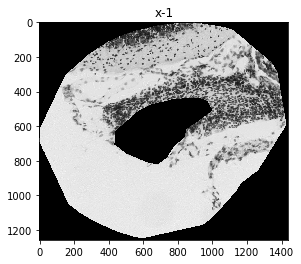

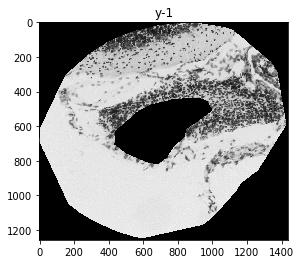

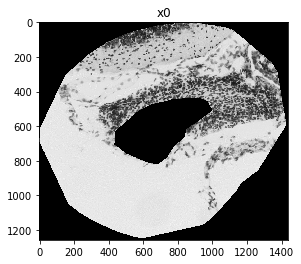

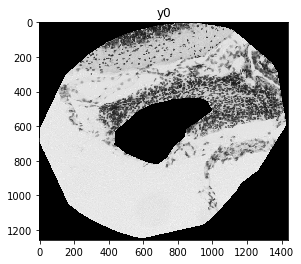

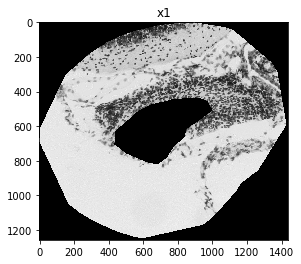

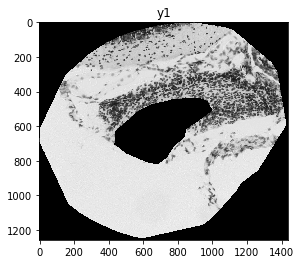

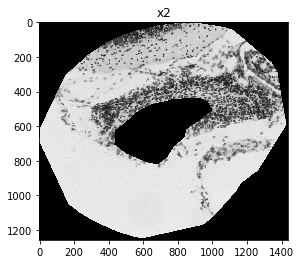

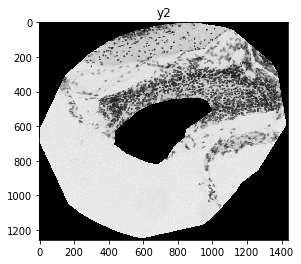

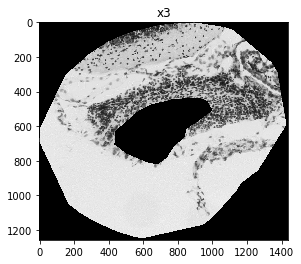

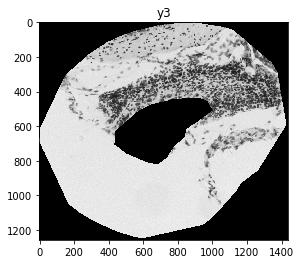

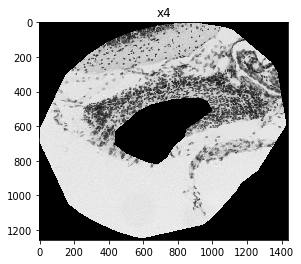

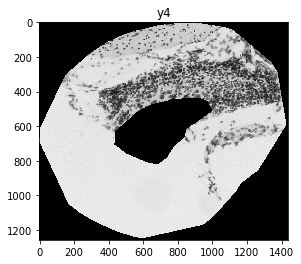

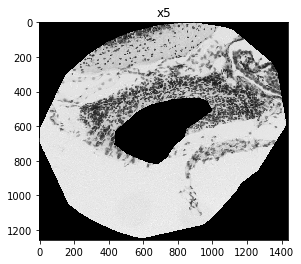

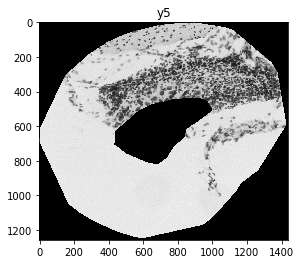

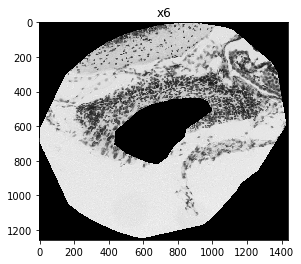

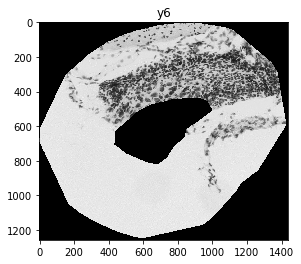

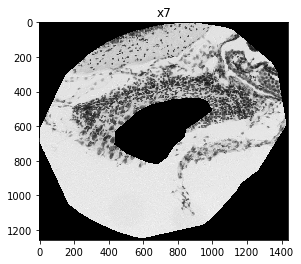

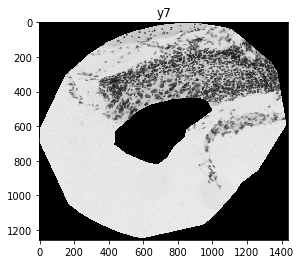

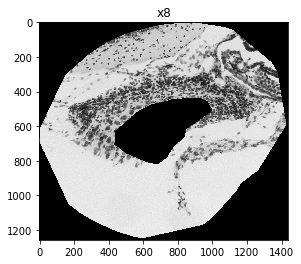

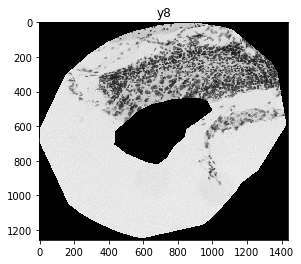

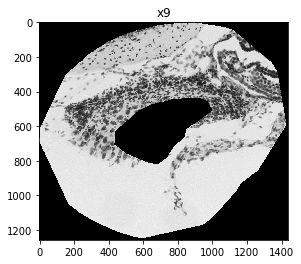

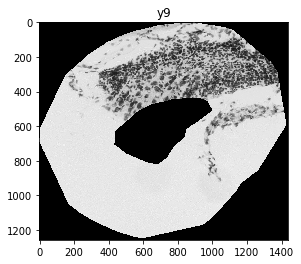

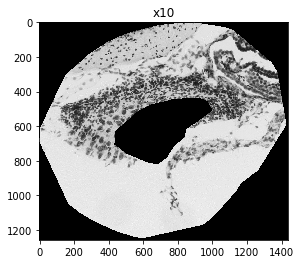

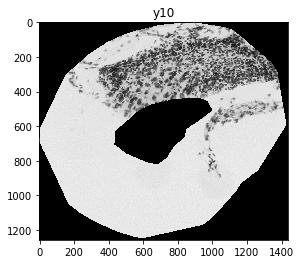

In [36]:
t1 =time()
grid_fn = features_fn + str(section) + '.pkl'
grid_features = {}
count = 0
Scores = {}
for contour_id, contour in polygons:
    structure = contour_id
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    # subpath = savepath + structure + '/'
    # if not os.path.exists(os.environ['ROOT_DIR']+subpath):
    #     os.mkdir(os.environ['ROOT_DIR']+subpath)

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        features.extend(np.array(clouds))
        labels.extend([1 - state] * len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train = features
    y_train = labels
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n - 1)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m - 1))]
    xs, ys = np.meshgrid(np.arange(left, right + 1), np.arange(up, down + 1), indexing='xy')
    locations = np.c_[xs.flat, ys.flat]

    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    indices_in = locations[indices_inside]
    x_raw = indices_in[:, 0] - left
    y_raw = indices_in[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_in)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section)+'_positive'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10,11):
        try:
            nleft = int(max(left+i*step_size, 0))
            nright = int(min(right+i*step_size, n-1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:,int(nleft -left-i*step_size):\
                                                         int(nleft -left-i*step_size)+nright - nleft + 1]
            
            plt.figure()
            plt.imshow( patch, cmap='gray')
            plt.title('x'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_x_'+str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch,'positive',params,extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up+i*step_size, 0))
            ndown = int(min(down+i*step_size, n-1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup -up-i*step_size):\
                                                         int(nup -up-i*step_size)+ndown - nup + 1, :]
            plt.figure()
            plt.imshow( patch, cmap='gray')
            plt.title('y'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'positive', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section)+'_positive']['x'] = x_shift
    Scores[structure][str(section)+'_positive']['y'] = y_shift


    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))

    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    indices_out = locations[indices_outside]
    x_raw = indices_out[:, 0] - left
    y_raw = indices_out[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_out)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section) + '_negative'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10, 11):
        try:
            nleft = int(max(left + i * step_size, 0))
            nright = int(min(right + i * step_size, n - 1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:, int(nleft - left - i * step_size): \
                                                            int(nleft - left - i * step_size) + nright - nleft + 1]
            plt.figure()
            plt.imshow( patch, cmap='gray')
            plt.title('x'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_x_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up + i * step_size, 0))
            ndown = int(min(down + i * step_size, n - 1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup - up - i * step_size): \
                                                              int(nup - up - i * step_size) + ndown - nup + 1, :]
            plt.figure()
            plt.imshow( patch, cmap='gray')
            plt.title('y'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section) + '_negative']['x'] = x_shift
    Scores[structure][str(section) + '_negative']['y'] = y_shift

    filename = savepath + str(section)+ '.pkl'
    pickle.dump(Scores, open(os.environ['ROOT_DIR'] + filename, 'wb'))
    setup_upload_from_s3(filename, recursive=False)
    count += 1
    print(section, structure, count, '/', len(polygons))

pickle.dump(grid_features, open(os.environ['ROOT_DIR'] + grid_fn, 'wb'))
setup_upload_from_s3(grid_fn, recursive=False)
os.remove(os.environ['ROOT_DIR']+img_fn)
print(str(section) + ' finished in %5.1f seconds' % (time() - t1))

In [37]:
scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))

In [38]:
scores['VCA']['94_negative']['x']

[array([-2.381804], dtype=float32),
 array([-1.4820213], dtype=float32),
 array([-0.6011723], dtype=float32),
 array([-2.9170392], dtype=float32),
 array([-3.7644818], dtype=float32),
 array([-3.5637646], dtype=float32),
 array([-3.4773939], dtype=float32),
 array([-2.680367], dtype=float32),
 array([-3.26092], dtype=float32),
 array([-2.8669538], dtype=float32),
 array([-2.9041762], dtype=float32),
 array([-1.965823], dtype=float32),
 array([-2.6814485], dtype=float32),
 array([-1.9228692], dtype=float32),
 array([-1.041024], dtype=float32),
 array([-0.67314583], dtype=float32),
 array([-0.65185606], dtype=float32),
 array([-2.19136], dtype=float32),
 array([-0.30115363], dtype=float32),
 array([-0.5934832], dtype=float32),
 array([0.06331888], dtype=float32)]

In [34]:
scores['VCA']['94_negative']['x']

[array([-2.381804], dtype=float32),
 array([-1.4820213], dtype=float32),
 array([-0.6011723], dtype=float32),
 array([-2.9170392], dtype=float32),
 array([-3.7644818], dtype=float32),
 array([-3.5637646], dtype=float32),
 array([-3.4773939], dtype=float32),
 array([-2.680367], dtype=float32),
 array([-3.26092], dtype=float32),
 array([-2.8669538], dtype=float32),
 array([-2.9041762], dtype=float32),
 array([-1.965823], dtype=float32),
 array([-2.6814485], dtype=float32),
 array([-1.9228692], dtype=float32),
 array([-1.041024], dtype=float32),
 array([-0.67314583], dtype=float32),
 array([-0.65185606], dtype=float32),
 array([-2.19136], dtype=float32),
 array([-0.30115363], dtype=float32),
 array([-0.5934832], dtype=float32),
 array([0.06331888], dtype=float32)]